In [2]:
import torch
import pandas as pd
from PIL import Image
import xgboost as xgb
import matplotlib.pyplot as plt

from pathlib import Path
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVR, SVR
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from transformers import ConvNextImageProcessor, ConvNextForImageClassification, AutoImageProcessor, AutoModel
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

c:\Users\fmore\anaconda3\envs\envnestedai\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Text ONLY

In [ ]:
txt_dataset_path = Path("./data/processed_text_data/dataset.csv")

## Preparation

In [ ]:
df = pd.read_csv(txt_dataset_path)

In [4]:
target = "Price"

X = df.drop(columns=[target])
y = df[target]

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

In [6]:
encoded_var = ["city"]
numerical_var = X.columns.drop(encoded_var)

In [7]:
transformer = ColumnTransformer(transformers=[
    ("num", StandardScaler(), numerical_var),
    ("cat", OneHotEncoder(sparse_output=False, max_categories=14, handle_unknown='infrequent_if_exist'), encoded_var),
])

## Model Training

### Random forest

In [83]:
pipeline = Pipeline(steps=[
    ("transformer", transformer),
    ("estimator", RandomForestRegressor())
])

In [111]:
parameters = {
    "transformer__cat__max_categories": [4, 8, 11, 14],
    "estimator__max_depth": [None, 3, 5, 7],
    "estimator__n_estimators": [50, 100, 150, 200],
    "estimator__criterion": ['squared_error', 'absolute_error']
}

grid = GridSearchCV(pipeline, parameters, verbose=1)

In [ ]:
grid.fit(X_train, y_train)

In [107]:
y_pred = grid.best_estimator_.predict(X_test)

In [108]:
mean_squared_error(y_test, y_pred)

57295102343.10741

In [109]:
mean_absolute_error(y_test, y_pred)

150687.0874766355

In [ ]:
# Feature importance
dict(
    sorted(
        zip(
            pipeline[0].get_feature_names_out(),
            pipeline[-1].feature_importances_
        ),
    key=lambda x: x[1],
    reverse=True)
)

{'num__Area': 0.44651039644402435,
 'num__Number of bathrooms': 0.1364917069377508,
 'num__density': 0.12188830523240361,
 'cat__city_Thousand Palms': 0.09492802022935538,
 'cat__city_Santa Barbara': 0.06716105580556059,
 'num__Number of Bedrooms': 0.03988523731105084,
 'num__population': 0.03891211272545268,
 'cat__city_Scottsdale': 0.008812136659172092,
 'cat__city_infrequent_sklearn': 0.008783145826446898,
 'cat__city_Acton': 0.00783432699285205,
 'cat__city_Laguna Niguel': 0.007237138452053727,
 'cat__city_Shasta Lake': 0.006338858253336062,
 'cat__city_Paso Robles': 0.0056612311727756385,
 'cat__city_Alameda': 0.0028637732837177516,
 'cat__city_Alpine': 0.0026622290240071247,
 'cat__city_El Cajon': 0.0017886777596426188,
 'cat__city_Antioch': 0.0014085495006571382,
 'cat__city_Eastvale': 0.0007416393187683148,
 'cat__city_Loma': 9.145907097237153e-05}

In [77]:
pipeline = Pipeline(steps=[
    ("transformer", transformer),
    ("estimator", LinearSVR())
])

In [78]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['Number of Bedrooms', 'Number of bathrooms', 'Area', 'population',
       'density'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                                max_categories=14,
                                                                sparse_output=False),
                                                  ['city'])])),
                ('estimator', LinearSVR())])

In [79]:
y_pred = pipeline.predict(X_test)

In [80]:
mean_squared_error(y_test, y_pred)

443123409561.7477

In [81]:
mean_absolute_error(y_test, y_pred)

551954.9813084112

### xgBoost

In [101]:
data_pipeline = Pipeline([
    ('transform', transformer)
])

X_train_processed = data_pipeline.fit_transform(X_train)
X_test_processed = data_pipeline.transform(X_test)

eval_set = [(X_train_processed, y_train), (X_test_processed, y_test)]
eval_metric = ['rmse']

params = {
    'objective': 'reg:squarederror',  # For regression tasks
    'eval_metric': 'rmse',  # Root Mean Square Error (RMSE) as loss function
    'learning_rate': 0.01,
    'n_estimators': 1000,
}

model = xgb.XGBRegressor()
model.set_params(
    objective=params['objective'],
    eval_metric=params['eval_metric'],
    learning_rate=params['learning_rate'],
    n_estimators=params['n_estimators']
)
bst = model.fit(X_train_processed, y_train, eval_set=eval_set, verbose=True)

[0]	validation_0-rmse:533858.29978	validation_1-rmse:372605.68417
[1]	validation_0-rmse:530875.09361	validation_1-rmse:370300.91467
[2]	validation_0-rmse:527927.48810	validation_1-rmse:368042.93138
[3]	validation_0-rmse:525015.08003	validation_1-rmse:365831.36980
[4]	validation_0-rmse:522137.57152	validation_1-rmse:363665.89019
[5]	validation_0-rmse:519294.60053	validation_1-rmse:361546.10798
[6]	validation_0-rmse:516485.70488	validation_1-rmse:359470.67817
[7]	validation_0-rmse:513710.72976	validation_1-rmse:357438.20577
[8]	validation_0-rmse:510969.34597	validation_1-rmse:355453.23712
[9]	validation_0-rmse:508261.10707	validation_1-rmse:353509.62001
[10]	validation_0-rmse:505585.77607	validation_1-rmse:351609.89720
[11]	validation_0-rmse:502943.03997	validation_1-rmse:349754.40478
[12]	validation_0-rmse:500332.54196	validation_1-rmse:347943.22002
[13]	validation_0-rmse:497753.99230	validation_1-rmse:346172.83089
[14]	validation_0-rmse:495207.01413	validation_1-rmse:344445.35771
[15]	

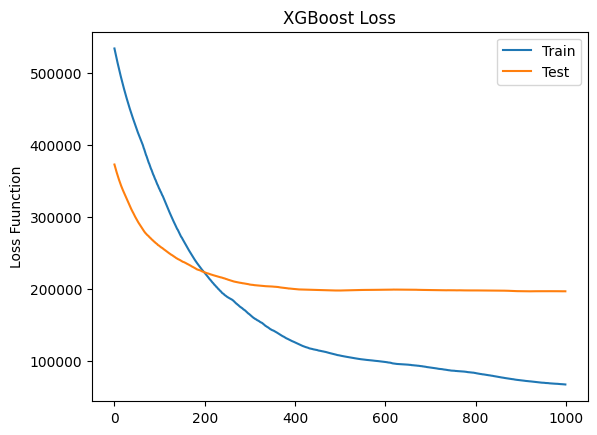

In [102]:
results = model.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)

fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
ax.plot(x_axis, results['validation_1']['rmse'], label='Test')
ax.legend()
plt.ylabel('Loss Fuunction')
plt.title('XGBoost Loss')
plt.show()

In [104]:
y_pred = model.predict(X_test_processed)

print(f"MSE : {mean_squared_error(y_test, y_pred)}")
print(f"MAE : {mean_absolute_error(y_test, y_pred)}")

MSE : 38584142119.77426
MAE : 129328.94158878505


# Text + Image

In [21]:
txt_dataset_path = Path("./data/global_df_augm.csv")
img_features_dataset_path = Path("./data/img_IMPORTANT_features_dataset_dinoV2_small.csv")

## Preparation

In [29]:
txt_dataset = pd.read_csv(txt_dataset_path, index_col='ID_augm')
img_features_dataset = pd.read_csv(img_features_dataset_path, index_col=0)

txt_cols = ["Number of Bedrooms", "Number of bathrooms", "Area", "Price", "city", "population", "density"]
txt_dataset = txt_dataset[txt_cols]

df = pd.merge(txt_dataset, img_features_dataset, left_index=True, right_index=True)

In [30]:
target = "Price"

X = df.drop(columns=[target])
y = df[target]

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

In [34]:
encoded_var = ["city"]
img_features = [col for col in X.columns if col.startswith("feature_")]
numerical_var = X.columns.drop(encoded_var + img_features)

In [35]:
transformer = ColumnTransformer(transformers=[
    ("num", StandardScaler(), numerical_var),
    ("cat", OneHotEncoder(sparse_output=False, max_categories=14, handle_unknown='infrequent_if_exist'), encoded_var),
])

## Model Training

In [36]:
data_pipeline = Pipeline([
    ('transform', transformer)
])

X_train_processed = data_pipeline.fit_transform(X_train)
X_test_processed = data_pipeline.transform(X_test)

eval_set = [(X_train_processed, y_train), (X_test_processed, y_test)]
eval_metric = ['rmse']

params = {
    'objective': 'reg:squarederror',  # For regression tasks
    'eval_metric': 'rmse',  # Root Mean Square Error (RMSE) as loss function
    'learning_rate': 0.01,
    'n_estimators': 1000,
}

model = xgb.XGBRegressor()
model.set_params(
    objective=params['objective'],
    eval_metric=params['eval_metric'],
    learning_rate=params['learning_rate'],
    n_estimators=params['n_estimators']
)
bst = model.fit(X_train_processed, y_train, eval_set=eval_set, verbose=True)

[0]	validation_0-rmse:521143.49244	validation_1-rmse:438375.50499
[1]	validation_0-rmse:518274.30546	validation_1-rmse:435540.80038
[2]	validation_0-rmse:515441.04653	validation_1-rmse:432724.68982
[3]	validation_0-rmse:512643.56124	validation_1-rmse:429954.43690
[4]	validation_0-rmse:509881.08364	validation_1-rmse:427213.68073
[5]	validation_0-rmse:507153.62247	validation_1-rmse:424508.47301
[6]	validation_0-rmse:504499.09841	validation_1-rmse:421832.03815
[7]	validation_0-rmse:501878.85683	validation_1-rmse:419126.64156
[8]	validation_0-rmse:499295.14654	validation_1-rmse:416502.76982
[9]	validation_0-rmse:496741.10435	validation_1-rmse:413825.16263
[10]	validation_0-rmse:494222.61193	validation_1-rmse:411199.94875
[11]	validation_0-rmse:491259.12440	validation_1-rmse:408723.79215
[12]	validation_0-rmse:488330.84569	validation_1-rmse:406285.07231
[13]	validation_0-rmse:485433.72460	validation_1-rmse:403891.79866
[14]	validation_0-rmse:482574.75523	validation_1-rmse:401524.43195
[15]	

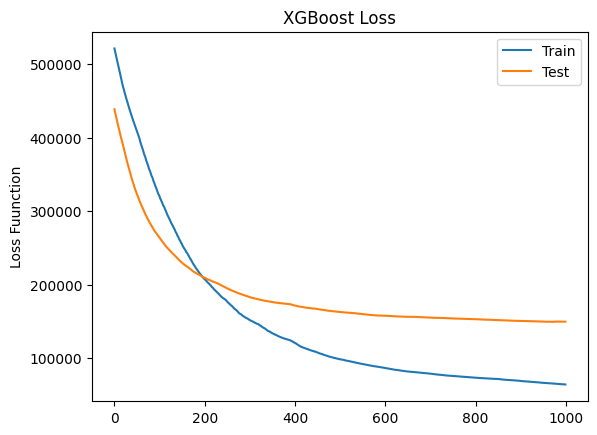

In [37]:
results = model.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)

fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
ax.plot(x_axis, results['validation_1']['rmse'], label='Test')
ax.legend()
plt.ylabel('Loss Fuunction')
plt.title('XGBoost Loss')
plt.show()

In [38]:
y_pred = model.predict(X_test_processed)

print(f"MSE : {mean_squared_error(y_test, y_pred)}")
print(f"MAE : {mean_absolute_error(y_test, y_pred)}")

MSE : 22345539030.79827
MAE : 69398.36580023365
